<h1 id="MNIST-Image-Classification ">MNIST Image Classification&nbsp;</h1>

<p>CNN model&nbsp;on MNIST using Estimator</p>

<p>&nbsp;</p>

<p>major steps:</p>

<ol>
	<li>image input from local data csv</li>
	<li>image reshape&nbsp;to [-1, HEIGHT, WIDTH,&nbsp; 1],&nbsp;serving_input_fn need to expand dim in feature</li>
	<li>label converted one_hot, use softmax cross entrocpy for loss&nbsp;</li>
	<li>build from keras and transform to estimator</li>
</ol>

<p>&nbsp;</p>


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import os

from sklearn.model_selection import train_test_split

import tensorflow as tf
print(tf.__version__)

#import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

tf.logging.set_verbosity(tf.logging.INFO)

1.13.1


### Exploring the data



In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [3]:
train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train.label.count()

42000

In [5]:
train_images = train.drop(labels = ["label"],axis = 1)
train_labels = train["label"]

train_images = train_images.to_numpy()/255.0
test_images = test.to_numpy()/255.0

In [6]:
HEIGHT = 28
WIDTH = 28
NCLASSES = 10

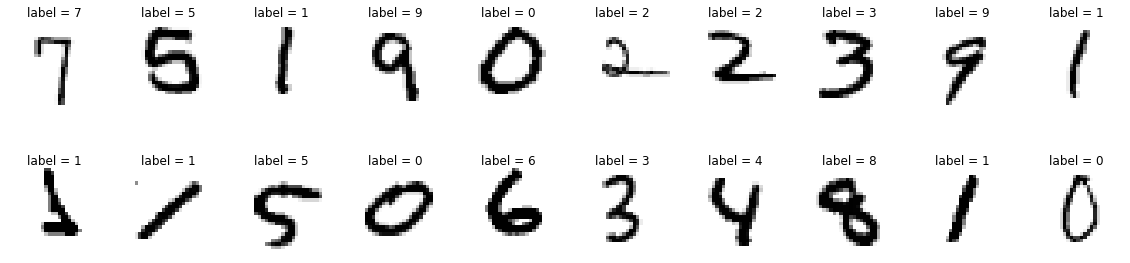

In [7]:
i = 50
plt.figure(figsize=(20,5))
for IMGNO in range(i,i+20):  
    plt.subplot(2, 10, IMGNO-i+1)
    plt.imshow(train_images[IMGNO].reshape(HEIGHT, WIDTH), cmap=plt.cm.binary)
    plt.title("label = %d" % train_labels[IMGNO],y=0.9)
    plt.axis('off')

In [8]:
train_labels.value_counts().sort_index()

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

In [10]:
train_images = train_images.reshape(-1,HEIGHT,WIDTH,1)
test_images = test_images.reshape(-1,HEIGHT,WIDTH,1)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes = NCLASSES)

In [11]:
train_labels[:3]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, test_size = 0.1)

len(Y_train)

37800

## Data augmentation

In [13]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

datagen.fit(X_train)

## Define a CNN model.


In [14]:
def get_model():

    X = tf.keras.layers.Input(shape = (HEIGHT, WIDTH, 1))

    c1 = tf.keras.layers.Conv2D(filters = 16, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu')(X)   # shape = (batch_size, HEIGHT, WIDTH, nfil1)

    #c1 = tf.keras.layers.BatchNormalization()(c1)          
                      
    p1 = tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2)(c1)                                                       # shape = (batch_size, HEIGHT // 2, WIDTH // 2, nfil1)
    
    c2 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu')(p1)    # shape = (batch_size, HEIGHT // 2, WIDTH // 2, nfil2)
    
    #c2 = tf.keras.layers.BatchNormalization()(c2)   

    p2 = tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2)(c2)                                                        # shape = (batch_size, HEIGHT // 4, WIDTH // 4, nfil2)

    c3 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(p2)    # shape = (batch_size, HEIGHT // 2, WIDTH // 2, nfil2)

    #c3 = tf.keras.layers.BatchNormalization()(c3)      

    p3 = tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2)(c3)                                                      # shape = (batch_size, HEIGHT // 4, WIDTH // 4, nfil2)

    p3 = tf.keras.layers.Flatten()(p3)                                                                               # shape = (batch_size, HEIGHT // 4 * WIDTH // 4 * nfil2)

    h3 = tf.keras.layers.Dense(units = 64, activation = 'relu')(p3)
    
    ##h3 = keras.layers.BatchNormalization()(h3)               
    
    h3 = tf.keras.layers.Dropout(rate = 0.25)(h3)

    output = tf.keras.layers.Dense(units = NCLASSES, activation = 'softmax')(h3)
  
    #output = keras.layers.BatchNormalization()(output)

    model = tf.keras.Model(inputs=X, outputs=output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

### train and evaluate

In [15]:
def train_and_evaluate(output_dir, hparams, X_train, X_val, Y_train, Y_val):
    
    model = get_model()
    model.summary()
    
    estimator = tf.keras.estimator.model_to_estimator(keras_model=model, 
                                                      model_dir=output_dir)

    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = X_train,
        y = Y_train,
        batch_size = hparams['batch_size'],
        num_epochs = hparams['epochs'],
        shuffle = True,
        queue_capacity = 5000
    )

    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = X_val,
        y = Y_val,
        batch_size = hparams['batch_size'],
        num_epochs = 1,
        shuffle = False,
        queue_capacity = 5000 #TODO   
    )
    
 
    estimator.train(input_fn=train_input_fn)
    
    eval_results = estimator.evaluate(input_fn=eval_input_fn)
    
    

#   
#    exporter = tf.estimator.LatestExporter(name = "exporter", serving_input_receiver_fn = serving_input_fn)
#
#    tf.estimator.train_and_evaluate(estimator = estimator, train_spec = train_spec, eval_spec = eval_spec)


### Input functions for training, evaluation, and predicition.

In [16]:
def serving_input_fn():

    feature_placeholders = tf.placeholder(dtype = tf.float32, shape = [None, HEIGHT, WIDTH])

    features = tf.expand_dims(input = feature_placeholders["image"], axis = -1)
    return tf.estimator.export.ServingInputReceiver(features =  features, receiver_tensors =  feature_placeholders)

## train locally


In [17]:
np.shape(X_train)

(37800, 28, 28, 1)

In [18]:
OUTDIR = "mnist\learned_v02"
shutil.rmtree(path = OUTDIR, ignore_errors = True) # start fresh each time


hparams = {"epochs": 20, "batch_size": 100, "learning_rate": 0.001, "batch_norm":0 }

train_and_evaluate(OUTDIR, hparams, X_train, X_val, Y_train, Y_val)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)    

INFO:tensorflow:Warm-starting variable: training/Adam/Variable_25; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: training/Adam/Variable_26; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: training/Adam/Variable_27; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: training/Adam/Variable_28; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: training/Adam/Variable_29; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into mnist\learned_v02\model.ckpt.
INFO:tensorflow:loss = 2.3133626, step = 1
INFO:tensorflow:global_step/sec: 7.56129
INFO:tensorflow:loss = 0.4425235, step = 101 (13.225 sec)
INFO:tensorflow:global_step/sec: 6.67907
INFO:tensorflow:loss = 0.22338372,

INFO:tensorflow:loss = 0.006980445, step = 7001 (13.216 sec)
INFO:tensorflow:global_step/sec: 7.54895
INFO:tensorflow:loss = 0.008534533, step = 7101 (13.247 sec)
INFO:tensorflow:global_step/sec: 7.55787
INFO:tensorflow:loss = 0.020243654, step = 7201 (13.231 sec)
INFO:tensorflow:global_step/sec: 7.51047
INFO:tensorflow:loss = 0.027749307, step = 7301 (13.315 sec)
INFO:tensorflow:global_step/sec: 7.61053
INFO:tensorflow:loss = 0.0013114085, step = 7401 (13.280 sec)
INFO:tensorflow:global_step/sec: 7.54895
INFO:tensorflow:loss = 0.015514713, step = 7501 (13.106 sec)
INFO:tensorflow:Saving checkpoints for 7561 into mnist\learned_v02\model.ckpt.
INFO:tensorflow:Loss for final step: 0.005686195.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Starting evaluation at 2019-08-18T18:13:37Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this pr

In [22]:
#feature_spec = {
#    input_name: tf.FixedLenFeature(shape=[784], dtype=np.float32)
#}
#serving_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(feature_spec)
#export_dir = classifier.export_savedmodel(export_dir_base="models/export", 
#                            serving_input_receiver_fn=serving_fn)
#export_dir = export_dir.decode("utf8")

#predict_results = est_catvsdog.predict(
#    input_fn=lambda: imgs_input_fn(test_files[:10], 
#                                   labels=None, 
#                                   perform_shuffle=False,
#                                   batch_size=10))
#predict_logits = []
#for prediction in predict_results:
#    predict_logits.append(prediction['dense_2'][0])

<p>results comparison</p>

<table align="left" border="2" cellpadding="1" cellspacing="1" style="width: 500px">
	<thead>
		<tr>
			<th scope="col">kaggle score</th>
			<th scope="col">rank</th>
			<th scope="col">data augmentation</th>
			<th scope="col">model build</th>
			<th scope="col">epochs</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<td>0.99057</td>
			<td>&nbsp;</td>
			<td>No</td>
			<td>keras</td>
			<td>20</td>
		</tr>
		<tr>
			<td>0.99024</td>
			<td>&nbsp;</td>
			<td>No</td>
			<td>keras to estimator</td>
			<td>20</td>
		</tr>
		<tr>
			<td>0.99257</td>
			<td>910</td>
			<td>Yes</td>
			<td>keras</td>
			<td>20</td>
		</tr>
		<tr>
			<td>0.99457</td>
			<td>655</td>
			<td>Yes</td>
			<td>keras</td>
			<td>30</td>
		</tr>
	</tbody>
</table>


<h2 id="notes">notes</h2>

<p>when building keras model use&nbsp;<em>model = tf.keras.Model(inputs=X, outputs=output)</em>. Do NOT use <em>keras.Model</em> which gives the follow error&nbsp;</p>

<pre>
ValueError: (&#39;Expected `model` argument to be a `Model` instance, got &#39;, &lt;keras.engine.training.Model object at 0x000002C3A950F2B0&gt;)</pre>

<p>actually, for consistency and avoiding incompatible issues, use <em>tf.keras</em> all the way.</p>


<h2 id="Next-steps">Next steps</h2>

<ol>
	<li>impletment prediction, collect log info, save model</li>
	<li>data augmentation and learning rate</li>
	<li>create GCP training files</li>
	<li>ensemble method</li>
	<li>TF2</li>
</ol>

<h2 id="Credits">Credits</h2>

<p><a href="https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive/08_image/mnistmodel/trainer/model.py" target="_blank">https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive/08_image/mnistmodel/trainer/model.py</a></p>

<p><a href="https://www.tensorflow.org/tutorials/estimators/cnn" target="_blank">https://www.tensorflow.org/tutorials/estimators/cnn</a></p>

<p><a href="https://www.tensorflow.org/guide/estimators" target="_blank">https://www.tensorflow.org/guide/estimators</a></p>

<p>&nbsp;</p>

<p>&nbsp;</p>
